To Do:
- Bollinger bands differences
- Create wrapper function to in bulk create TAs
- Transplant useful functions from previous project into this directory, such as the methods to concatenate seperate datasets and backtest
- More clearly define the initial trading paradigm

In [1]:
# Import packages
%load_ext autoreload
%autoreload 1

import pandas as pd
import numpy as np
import tensorflow as tf
from pathlib import Path
from datetime import date, timedelta
import os
import sys
import time
import pickle
from termcolor import colored 
import talib
import matplotlib.pyplot as plt
from progress.bar import Bar

from alpha_vantage.timeseries import TimeSeries
from alpha_vantage.cryptocurrencies import CryptoCurrencies

In [2]:
# Import files from alphavantage_datapull
%aimport alphavantage_datapull.load_tickers
%aimport alphavantage_datapull.pull_data_gen
%aimport alphavantage_datapull.pull_data_av
%aimport alphavantage_datapull.pull_data_binance

from alphavantage_datapull.load_tickers import *
from alphavantage_datapull.pull_data_gen import *
from alphavantage_datapull.pull_data_av import *
from alphavantage_datapull.pull_data_binance import *

In [3]:
# Import files from preprocessing
%aimport preprocessing.preprocessing_timeseries
%aimport preprocessing.preprocessing_gen


from preprocessing.preprocessing_timeseries import *
from preprocessing.preprocessing_gen import *

In [4]:
# Import files from neural_network

%aimport neural_network.network_construction
%aimport neural_network.network_evaluation
%aimport neural_network.network_training

from neural_network.network_construction import *
from neural_network.network_evaluation import *
from neural_network.network_training import *

In [5]:
# Check package versions

print("TensorFlow Version: ", tf.__version__)

TensorFlow Version:  2.0.0


In [6]:
# Check GPU recognition

from tensorflow.python.client import device_lib
print("GPUs: ", device_lib.list_local_devices(), "\n")

GPUs:  [name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12281173698582173854
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4855863705
locality {
  bus_id: 1
  links {
  }
}
incarnation: 17973800637182697482
physical_device_desc: "device: 0, name: GeForce GTX 1660 SUPER, pci bus id: 0000:06:00.0, compute capability: 7.5"
] 



In [7]:
# Import API keys

from API_keys import Quandl_api_key, AlphaVantage_api_key

In [8]:
# Load Tickers

sp100_ticker_df = load_sp100_tickers()
crypto_tickers_df = load_digital_currency_top50_tickers()

In [9]:
# Set up TimeSeries and CryptoCurencies

ts = TimeSeries(key=AlphaVantage_api_key, output_format='pandas')
cc = CryptoCurrencies(key=AlphaVantage_api_key, output_format='pandas')

In [10]:
# Creat data cache daily folder if necessary

today = str(date.today())

base_cache = Path("data_cache/") / today

# Setup api call counter
api_call_counter = get_api_call_counter(base_cache)

Value of api_call_counter:  10


In [11]:
'''
THIS CELL: ONLY TO SAVE MYSELF SOME TIME TODAY
'''
today = str(date.today() - timedelta(days=1))
base_cache = Path("data_cache/") / today

In [12]:
pull_stock_fund_intraday_av(sp100_ticker_df, ts, base_cache)

Value of api_call_counter:  168
Data for ABBV already exists
Data for ABT already exists
Data for ACN already exists
Data for ADBE already exists
Data for AGN already exists
Data for AIG already exists
Data for ALL already exists
Data for AMGN already exists
Data for AMT already exists
Data for AMZN already exists
Data for AXP already exists
Data for BA already exists
Data for BAC already exists
Data for BIIB already exists
Data for BK already exists
Data for BKNG already exists
Data for BLK already exists
Data for BMY already exists
Data for C already exists
Data for CAT already exists
Data for CHTR already exists
Data for CL already exists
Data for CMCSA already exists
Data for COF already exists
Data for COP already exists
Data for COST already exists
Data for CSCO already exists
Data for CVS already exists
Data for CVX already exists
Data for DD already exists
Data for DHR already exists
Data for DIS already exists
Data for DOW already exists
Data for DUK already exists
Data for EM

In [13]:
# Plat with technical indicators

amzn_df = open_single_intraday('AMZN', base_cache)
display(amzn_df.head())

,date,1. open,2. high,3. low,4. close,5. volume
0,2020-04-15 09:31:00,2255.4099,2257.0251,2246.0000,2246.5081,228355.0
1,2020-04-15 09:32:00,2248.0549,2251.8501,2245.0000,2249.3003,45593.0
2,2020-04-15 09:33:00,2250.0000,2262.7300,2248.3911,2262.7300,37972.0
3,2020-04-15 09:34:00,2255.0530,2255.0530,2255.0530,2255.0530,41403.0
4,2020-04-15 09:35:00,2259.7000,2259.7000,2259.3132,2259.3132,25192.0


In [14]:
# Sandbox

close = amzn_df['4. close']
upper, middle, lower = talib.BBANDS(close, matype=talib.MA_Type.T3)

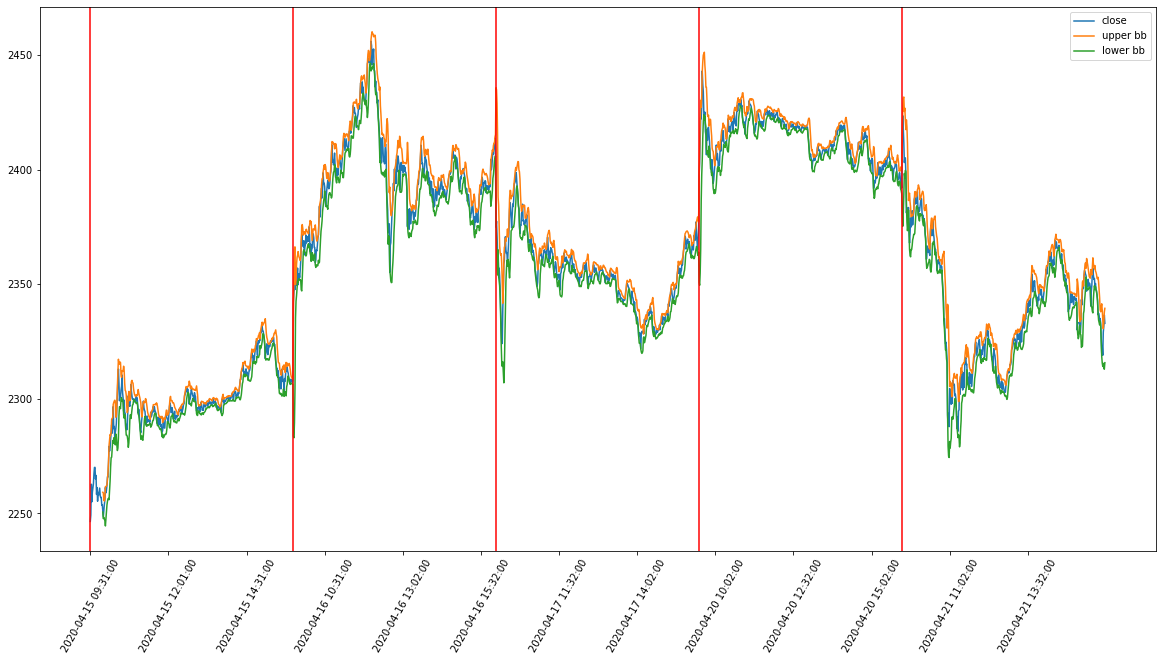

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
datetime_list = amzn_df['date'].apply(str)
open_time_args = []
for i, datetime in enumerate(datetime_list):
    if '9:31' in datetime:
        open_time_args.append(i)
        
dummy_values = np.arange(0,len(amzn_df['date']),1)
ax.plot(dummy_values, close, label="close")
ax.plot(dummy_values, upper, label="upper bb")
ax.plot(dummy_values, lower, label="lower bb")
ax.legend()
plt.xticks(dummy_values[::150],amzn_df['date'][::150]) # rotation=60)
plt.xticks(rotation=60)

# Return all args of date where time contains 9:31
for x in open_time_args:
    ax.axvline(x=x, c='r')
plt.show()

### Prior to implementing NN, recall essential practices
- Scaling with sklearn
- Consider model validation
- Remove ticker before scaling and putting into nn - for human analysis only

In [16]:
'''
join_timeseries is a candidate for acceleration
'''

# Put all df into master list with ticker as a col
df_list = []
for ticker in sp100_ticker_df.ticker:
    ticker_df = open_single_intraday(ticker, base_cache)
    ticker_col = np.full(len(ticker_df), ticker)
    ticker_df['ticker'] = ticker_col    
    ticker_df.columns = [str(col) + '_' + ticker for col in ticker_df.columns]
    ticker_df = ticker_df.rename(columns={("date_" + ticker): "date"})
    df_list.append(ticker_df)
    
# Aggregate df_list
master_df = join_timeseries(df_list)

In [17]:
# Cut all non-numeric data
master_numeric_df = master_df._get_numeric_data()
display(master_numeric_df)

# Generate differences
master_numeric_diff_df = gen_diff(master_numeric_df, period = 5)
display(master_numeric_diff_df)

,1. open_ABBV,2. high_ABBV,3. low_ABBV,4. close_ABBV,5. volume_ABBV,1. open_ABT,2. high_ABT,3. low_ABT,4. close_ABT,5. volume_ABT,...,1. open_WMT,2. high_WMT,3. low_WMT,4. close_WMT,5. volume_WMT,1. open_XOM,2. high_XOM,3. low_XOM,4. close_XOM,5. volume_XOM
0,80.4102,80.4102,80.4102,80.4102,210463.0,89.6800,89.68,89.68,89.6800,476743.0,...,128.56,128.56,128.5600,128.56,272199.0,40.5550,40.5550,40.555,40.5550,1249926.0
1,80.4500,80.7900,80.3300,80.7700,31720.0,89.6400,90.00,89.64,89.9506,129104.0,...,128.55,129.00,128.3600,128.57,37468.0,40.5400,40.6100,40.430,40.5000,119668.0
2,80.7900,81.1000,80.7300,81.0750,34792.0,89.9965,90.75,89.94,90.6050,118858.0,...,128.65,128.93,128.4698,128.55,22881.0,40.4800,40.5816,40.290,40.5149,181743.0
3,81.0250,81.0250,80.7300,80.7300,14058.0,90.6300,90.75,90.54,90.7050,87467.0,...,128.60,128.62,128.0700,128.17,13157.0,40.4850,40.5800,40.380,40.3900,85079.0
4,80.8100,81.0200,80.7500,80.9000,28496.0,90.7299,90.86,90.07,90.0700,103909.0,...,128.23,128.23,127.7500,127.75,19305.0,40.3809,40.5200,40.380,40.4600,106675.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1945,80.4000,80.5300,80.3900,80.4100,40869.0,93.9900,94.11,93.99,94.0850,52204.0,...,129.84,129.98,129.7600,129.82,105811.0,41.2550,41.2700,41.160,41.1600,372563.0
1946,80.4150,80.5898,80.4150,80.5750,42333.0,94.0800,94.24,94.08,94.2400,61277.0,...,129.84,129.98,129.7600,129.82,105811.0,41.2550,41.2700,41.160,41.1600,372563.0
1947,80.5700,80.6100,80.4600,80.4800,53102.0,94.2200,94.23,94.17,94.2000,64492.0,...,129.84,129.98,129.7600,129.82,105811.0,41.2550,41.2700,41.160,41.1600,372563.0
1948,80.4900,80.6500,80.4900,80.6000,79666.0,94.2100,94.27,94.20,94.2500,63626.0,...,129.84,129.98,129.7600,129.82,105811.0,41.2550,41.2700,41.160,41.1600,372563.0


,1. open_ABBV_diff_5,2. high_ABBV_diff_5,3. low_ABBV_diff_5,4. close_ABBV_diff_5,5. volume_ABBV_diff_5,1. open_ABT_diff_5,2. high_ABT_diff_5,3. low_ABT_diff_5,4. close_ABT_diff_5,5. volume_ABT_diff_5,...,1. open_WMT_diff_5,2. high_WMT_diff_5,3. low_WMT_diff_5,4. close_WMT_diff_5,5. volume_WMT_diff_5,1. open_XOM_diff_5,2. high_XOM_diff_5,3. low_XOM_diff_5,4. close_XOM_diff_5,5. volume_XOM_diff_5
0,0.4898,0.5298,0.1398,0.1898,-195041.0,0.4100,0.4100,0.0700,0.2737,-416923.0,...,-0.710,-0.05,-0.7100,-0.05,-253588.0,-0.0950,-0.0850,-0.242,-0.2000,-1113644.0
1,0.1837,-0.1563,0.0000,-0.4300,-11119.0,0.3100,0.3419,0.2800,0.0842,-66633.0,...,-0.015,-0.13,0.1200,0.00,-13689.0,-0.1850,-0.1700,-0.110,-0.1200,-2428.0
2,-0.4600,-0.3700,-0.4300,-0.3650,-18302.0,0.0235,-0.0850,0.0800,0.0550,-52807.0,...,-0.120,-0.06,0.0602,0.18,-7583.0,-0.1000,-0.1416,0.020,-0.1249,-61464.0
3,-0.3700,-0.1696,-0.1050,0.0700,4919.0,0.0200,-0.0500,-0.1600,-0.2250,2736.0,...,0.090,0.48,0.5200,0.89,21553.0,-0.0950,-0.1300,0.000,0.0200,30459.0
4,-0.0500,-0.1100,-0.0400,-0.0600,4117.0,-0.2499,-0.2000,0.3200,0.3750,-44602.0,...,0.770,1.06,1.1500,1.39,6129.0,0.0291,-0.0838,-0.040,-0.0400,21239.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1940,-0.1700,-0.1400,-0.0700,-0.2100,-12858.0,-0.0800,-0.0400,0.0799,-0.0550,-29848.0,...,0.000,0.00,0.0000,0.00,0.0,0.0000,0.0000,0.000,0.0000,0.0
1941,-0.2050,-0.0702,-0.1450,-0.0650,2782.0,-0.0500,0.0600,0.0100,0.1600,19491.0,...,0.000,0.00,0.0000,0.00,0.0,0.0000,0.0000,0.000,0.0000,0.0
1942,-0.0900,-0.0500,0.0000,0.0121,21562.0,0.1200,0.1100,0.1400,0.1500,25483.0,...,0.000,0.00,0.0000,0.00,0.0,0.0000,0.0000,0.000,0.0000,0.0
1943,0.0200,0.1200,0.0700,0.1600,30578.0,0.1600,0.2150,0.3200,0.3250,20787.0,...,0.000,0.00,0.0000,0.00,0.0,0.0000,0.0000,0.000,0.0000,0.0


In [18]:
# Train test split
    
df_train, df_val, df_test = splitter(master_numeric_diff_df, 0.7, 0.1)

In [19]:
# Smooth and Scale
'''
smoother_scaler is a candidate for acceleration
'''

# Need this function to also return the scaler value
df_train, df_val, df_test = smoother_scaler(df_train, df_val, df_test)

In [20]:
display(df_train.head())

,1. open_ABBV_diff_5,2. high_ABBV_diff_5,3. low_ABBV_diff_5,4. close_ABBV_diff_5,5. volume_ABBV_diff_5,1. open_ABT_diff_5,2. high_ABT_diff_5,3. low_ABT_diff_5,4. close_ABT_diff_5,5. volume_ABT_diff_5,...,1. open_WMT_diff_5,2. high_WMT_diff_5,3. low_WMT_diff_5,4. close_WMT_diff_5,5. volume_WMT_diff_5,1. open_XOM_diff_5,2. high_XOM_diff_5,3. low_XOM_diff_5,4. close_XOM_diff_5,5. volume_XOM_diff_5
0,0.492049,0.556608,0.404404,0.376483,0.276877,0.629699,0.560248,0.567251,0.602403,0.303625,...,0.446328,0.632399,0.492497,0.605479,0.244088,0.647619,0.618350,0.608162,0.593516,0.155744
1,0.384834,0.368846,0.352047,0.156306,0.502513,0.610323,0.545796,0.608187,0.566547,0.464795,...,0.642655,0.607477,0.718963,0.619178,0.496887,0.623951,0.596651,0.642063,0.613466,0.502242
2,0.159370,0.310364,0.191004,0.179396,0.493701,0.554813,0.455201,0.569201,0.561022,0.471156,...,0.612994,0.629283,0.702647,0.668493,0.503321,0.646304,0.603901,0.675450,0.612244,0.483834
3,0.190893,0.365206,0.312722,0.333925,0.522189,0.554135,0.462629,0.522417,0.508042,0.496712,...,0.672316,0.797508,0.828104,0.863014,0.534024,0.647619,0.606862,0.670314,0.648379,0.512497
4,0.302977,0.381517,0.337066,0.287744,0.521205,0.501841,0.430797,0.615984,0.621570,0.474932,...,0.864407,0.978193,1.000000,1.000000,0.517771,0.680254,0.618656,0.660041,0.633416,0.509622


No handles with labels found to put in legend.


"\nfor x in open_time_args:\n    ax.axvline(x=x, c='r')\nplt.show()\n"

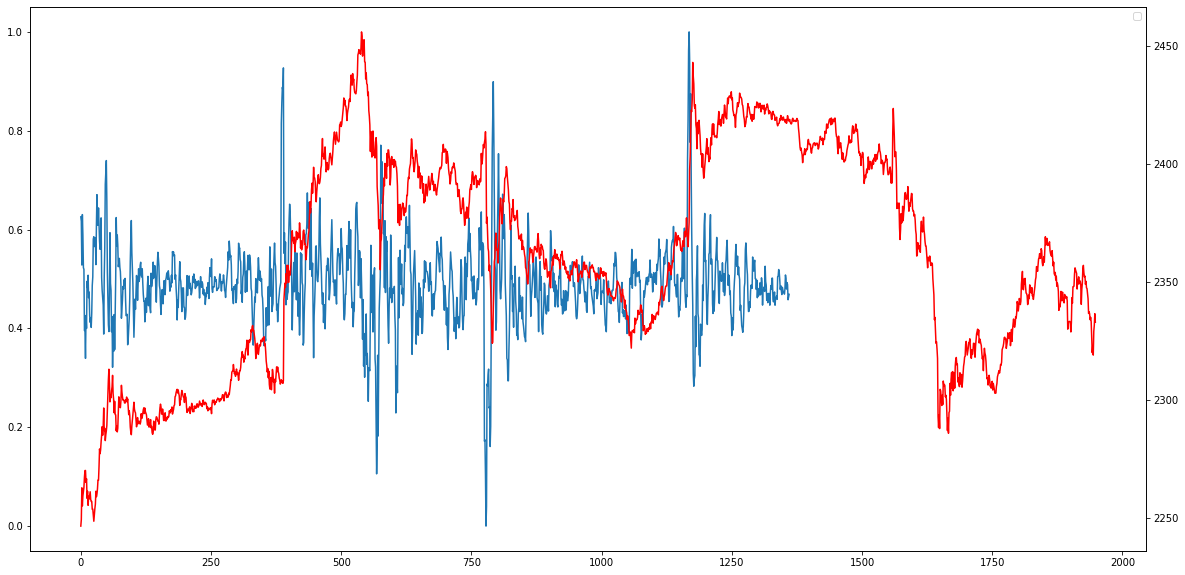

In [21]:
# Visualize smoothing and scaling

close = df_train['4. close_AMZN_diff_5']
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
'''
datetime_list = master_df['date'].apply(str)
open_time_args = []
for i, datetime in enumerate(datetime_list):
    if '9:31' in datetime:
        open_time_args.append(i)
'''
     
#dummy_values = np.arange(0,len(master_df['date']),1)
#ax.plot(dummy_values, close, label="close")
ax.plot(close)

ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
close2 = amzn_df['4. close']
ax2.plot(close2, c='r')



ax.legend()
# plt.xticks(dummy_values[::150],master_df['date'][::150]) # rotation=60)
# plt.xticks(rotation=60)

# Return all args of date where time contains 9:31
'''
for x in open_time_args:
    ax.axvline(x=x, c='r')
plt.show()
'''

In [22]:
'''
from os import walk, path, renamefor dirpath, _, files in walk(base_cache):
    for f in files:
        rename(path.join(dirpath, f), path.join(dirpath, path.join(f[:-4] + "_av" + ".csv")))
'''

'\nfrom os import walk, path, renamefor dirpath, _, files in walk(base_cache):\n    for f in files:\n        rename(path.join(dirpath, f), path.join(dirpath, path.join(f[:-4] + "_av" + ".csv")))\n'

In [36]:
# Hyperparameter Definition and Sequence Generation

'''
Hyperparameter Definition
'''

batch_size = 1
dropout = 0.1
epochs = 50
seq_length = 30

X_train, y_train = ltsm_sequence_generator(master_numeric_diff_df, seq_length, '4. close_AMZN_diff_5')
X_val, y_val = ltsm_sequence_generator(master_numeric_diff_df, seq_length, '4. close_AMZN_diff_5')

In [38]:
# Construct Neural Net
model = build_NN(X_train, batch_size, dropout)
model = add_Optimizer(model)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 30, 1024)          6225920   
_________________________________________________________________
dropout_3 (Dropout)          (None, 30, 1024)          0         
_________________________________________________________________
dense_2 (Dense)              (None, 30, 1024)          1049600   
_________________________________________________________________
lstm_4 (LSTM)                (None, 30, 512)           3147776   
_________________________________________________________________
dropout_4 (Dropout)          (None, 30, 512)           0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 128)               328192    
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)              

In [39]:
# Train Neural Net
model, history = train_Model(model, 
                             X_train, y_train, X_val, y_val, epochs, batch_size, early_stopping = 0)

Train on 1915 samples, validate on 1915 samples
Epoch 1/50
1915/1915 [==============================] - 48s 25ms/sample - loss: 71.2288 - val_loss: 71.2214
Epoch 2/50
1915/1915 [==============================] - 45s 24ms/sample - loss: 70.9898 - val_loss: 70.8132
Epoch 3/50
1915/1915 [==============================] - 43s 22ms/sample - loss: 70.4073 - val_loss: 69.1689
Epoch 4/50
1915/1915 [==============================] - 1168s 610ms/sample - loss: 67.5354 - val_loss: 66.3390
Epoch 5/50
1915/1915 [==============================] - 2394s 1s/sample - loss: 66.5088 - val_loss: 64.8063
Epoch 6/50
1915/1915 [==============================] - 1534s 801ms/sample - loss: 65.0424 - val_loss: 63.9610
Epoch 7/50
1915/1915 [==============================] - 1390s 726ms/sample - loss: 64.7457 - val_loss: 63.8482
Epoch 8/50
1915/1915 [==============================] - 198s 103ms/sample - loss: 64.0422 - val_loss: 63.7891
Epoch 9/50
1353/1915 [====================>.........] - ETA: 9s - loss: 68.95

KeyboardInterrupt: 

In [ ]:
# Evaluate Neural Net Training
training_loss = history.history['loss']
epoch_count = range(1, len(training_loss) + 1)
plt.plot(epoch_count, training_loss)

if 'val_loss' in history.history.keys():
    test_loss = history.history['val_loss']
    plt.plot(epoch_count, test_loss)
    plt.legend(['Training Loss', 'Val Loss'])
else:
    plt.legend(['Training Loss'])
    
plt.xlabel('Epoch')
plt.ylabel('Loss')

In [ ]:
# Evaluate Neural Net Inference Performace
close_pred, fig = evaluate_performance(model, master_df_train, master_df_test, 
                                   master_data_training, master_data_testing, seq_length, '4. close_AMZN_diff_5')